## 0. Подготовка

In [18]:
import numpy as np
import pandas as pd
import sklearn
import nearest_neighbors as nn, cross_validation as cv
import time
import seaborn as sns
import scipy.ndimage
import cv2
from sklearn import datasets
from matplotlib import pyplot as plt
from importlib import reload
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [178]:
def show_images_horizontally(X, label = '?.pdf'):
    list_of_files = []
    for image in X:
        pixels = image.reshape((28, 28))
        list_of_files.append(pixels)
    fig = plt.figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a = fig.add_subplot(1, number_of_files,i+1)
        image = list_of_files[i]
        plt.imshow(image,cmap='Greys_r')
        plt.axis('off')
    plt.savefig(label)

def show_img(image):
    plt.grid(False)
    plt.imshow(image,cmap='Greys_r')
    plt.axis('off')

In [20]:
data = datasets.fetch_openml('mnist_784', parser='auto')

X_train, X_test = np.array(data['data'][0:60000]), np.array(data['data'][60000:70000])
y_train, y_test = np.array(data['target'][0:60000]).astype(int), np.array(data['target'][60000:70000]).astype(int)

In [21]:
print('Train shape:   ', X_train.shape)
print('Test shape:    ', X_test.shape)
print('Y_train shape: ', y_train.shape)
print('Y_test shape:  ', y_test.shape)

Train shape:    (60000, 784)
Test shape:     (10000, 784)
Y_train shape:  (60000,)
Y_test shape:   (10000,)


In [22]:
model = nn.KNNClassifier(k=5, strategy='my_own', metric='euclidean', weights=False)
model.fit(X_train, y_train)

In [119]:
print(model.predict(X_test[:5]))

[7 2 1 0 4]


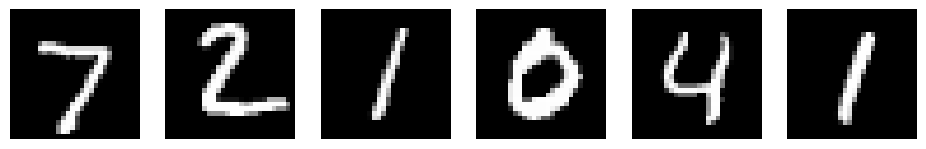

In [124]:
show_images_horizontally(X_test[:6])

## 1. Время работы алгоритмов при признаках 10, 20, 100

In [25]:
np.random.seed(777)
ten_features = np.random.randint(0,X_train.shape[1], 10)
twenty_features = np.random.randint(0,X_train.shape[1], 20)
hundred_features = np.random.randint(0,X_train.shape[1], 100)
features_subset = [ten_features, twenty_features, hundred_features]

In [26]:
print('10 признаков:', ten_features, '\n')
print('20 признаков:', twenty_features, '\n')
print('100 признаков:', hundred_features)

10 признаков: [103 571 599  71 669 639 116 423 506 295] 

20 признаков: [397 654  32 321 340 325 775 577 543 187 103  74 562 318 365 326 322 202
  60 783] 

100 признаков: [640 186 642  16 355 237 627 171 384 446 550 565  78  28 245  92 741 221
 225 276 407 138 228 516  80 361 356 117  16 341 399   0 309 695 729 701
 628  17 264 265 108 272  85 190 607 694  34 351 195 747 125 314 549  23
  44  91 109 574  23  30 199 263 543  99 339 342  20 336 447 292 456 637
 583 383 561 264 693 495 251 676 453 183 375  20 638 654 451 198 227 698
 707 294 374 395 298 654 616 171 604 440]


In [27]:
def get_times(model, X):
    times = []
    for indexes in features_subset:
        tick = time.perf_counter()
        model.fit(X_train[:,indexes], y_train)
        model.find_kneighbors(X_test[:,indexes])
        times.append(time.perf_counter() - tick)
    return times

In [28]:
%%time
own = nn.KNNClassifier(k=5, strategy='my_own', metric='euclidean', weights=False, test_block_size=500)
own_times = get_times(own, X_train)
own_times

CPU times: user 2min 39s, sys: 29 s, total: 3min 8s
Wall time: 3min 22s


[38.01105016702786, 40.040200166986324, 124.40486866701394]

In [29]:
%%time
brute = nn.KNNClassifier(k=5, strategy='brute', metric='euclidean', weights=False, test_block_size=500)
brute_times = get_times(brute, X_train)
brute_times

CPU times: user 2min 7s, sys: 7.57 s, total: 2min 15s
Wall time: 45.9 s


[13.923875999986194, 14.93644195899833, 17.023553458973765]

In [30]:
%%time
kd_tree = nn.KNNClassifier(k=5, strategy='kd_tree', metric='euclidean', weights=False)
kd_tree_times = get_times(kd_tree, X_train)
kd_tree_times

CPU times: user 2min 37s, sys: 1.45 s, total: 2min 38s
Wall time: 25.9 s


[0.4877923340536654, 0.5722306250827387, 24.848732582991943]

In [31]:
%%time
ball_tree = nn.KNNClassifier(k=5, strategy='ball_tree', metric='euclidean', weights=False)
ball_tree_times = get_times(ball_tree, X_train)
ball_tree_times

CPU times: user 3min 42s, sys: 1.66 s, total: 3min 43s
Wall time: 33.8 s


[1.3601603750139475, 3.230868582963012, 29.17452829098329]

In [32]:
df = pd.DataFrame()
df['number_of_features'] = [10, 20, 100]
df['my_own'] = own_times
df['brute'] = brute_times
df['kd_tree'] = kd_tree_times
df['ball_tree'] = ball_tree_times

df = df.set_index(['number_of_features']).stack().reset_index().rename(columns={'level_1': 'method', 0: 'secs'})
df

,number_of_features,method,secs
0,10,my_own,38.011050
1,10,brute,13.923876
2,10,kd_tree,0.487792
3,10,ball_tree,1.360160
4,20,my_own,40.040200
5,20,brute,14.936442
6,20,kd_tree,0.572231
7,20,ball_tree,3.230869
8,100,my_own,124.404869
9,100,brute,17.023553


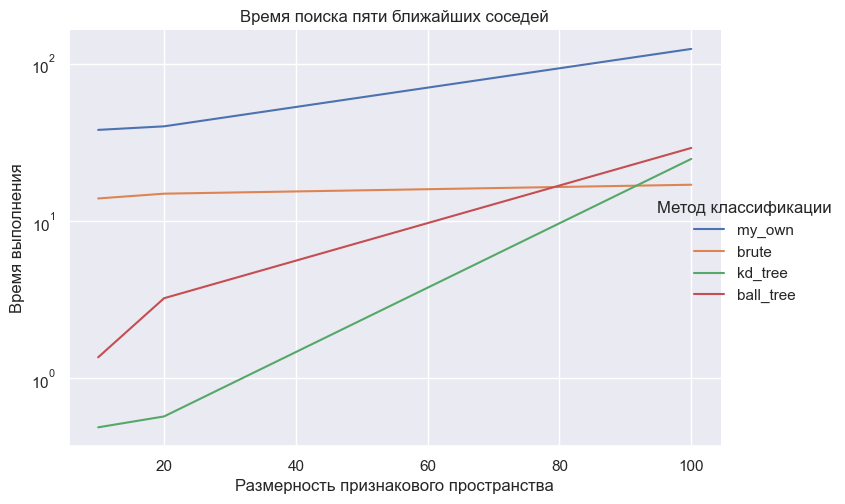

In [154]:
sns.set(rc={'figure.figsize':(12,8)})

sns.relplot(data = df, x = 'number_of_features', y = 'secs', 
            hue = 'method', kind = 'line', legend = 'auto', height=5, aspect=1.5)._legend.set_title('Метод классификации')

plt.yscale("log")

plt.xlabel('Размерность признакового пространства')
plt.ylabel('Время выполнения')
plt.title('Время поиска пяти ближайших соседей')
plt.grid(True)
plt.savefig('charts/times.jpg')

plt.show()

## 2. Перебор k и метрик

### 2.1 Перебор k

In [34]:
np.random.seed(777)

cv_split = cv.kfold(X_train.shape[0], 3)
klist = 1 + np.arange(10)

In [35]:
%%time
cross_val_scrore = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=klist, cv = cv_split, score = 'accuracy', 
                       strategy='kd_tree', metric='euclidean', weights=False) 
cross_val_scrore

CPU times: user 1h 26min 36s, sys: 1min 3s, total: 1h 27min 39s
Wall time: 14min 22s


{1: [0.96975, 0.96995, 0.9704],
 2: [0.9625, 0.96285, 0.96425],
 3: [0.96725, 0.97065, 0.97215],
 4: [0.9666, 0.96945, 0.97005],
 5: [0.9676, 0.9702, 0.9701],
 6: [0.96635, 0.96835, 0.96795],
 7: [0.96595, 0.9672, 0.96835],
 8: [0.9652, 0.96655, 0.96695],
 9: [0.96475, 0.96705, 0.966],
 10: [0.96395, 0.9659, 0.9651]}

In [36]:
mean_accuracy = np.mean(np.array(list(cross_val_scrore.values())), axis=1)
mean_accuracy

array([0.97003333, 0.9632    , 0.97001667, 0.9687    , 0.9693    ,
       0.96755   , 0.96716667, 0.96623333, 0.96593333, 0.96498333])

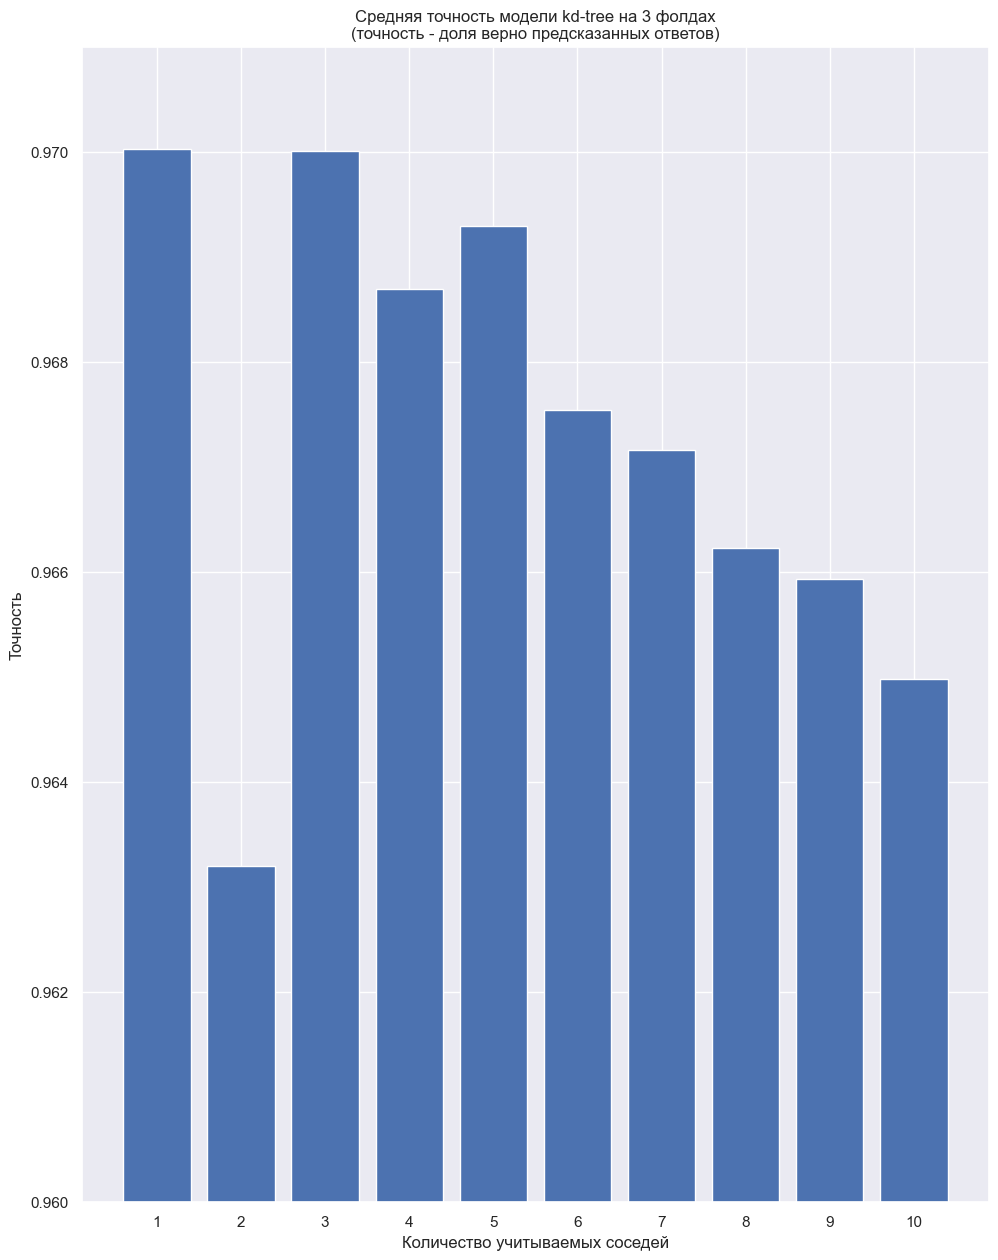

In [37]:
plt.bar(range(len(cross_val_scrore)), mean_accuracy, align='center')

plt.xticks(np.arange(10), 1+np.arange(10))
plt.yticks(0.96+0.002*np.arange(6))
plt.ylim((0.96,0.971))
plt.grid(True)
plt.xlabel('Количество учитываемых соседей')
plt.ylabel('Точность')
plt.title('Средняя точность модели kd-tree на 3 фолдах\n(точность - доля верно предсказанных ответов)')

plt.savefig('charts/k_cv.pdf')

plt.show()

### 2.2 Метрики

In [38]:
%%time

my_cs_score_euclid = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split, score = 'accuracy', 
                       strategy='my_own', metric='euclidean', weights=False, test_block_size=1000) 
my_cs_score_euclid

CPU times: user 19min 41s, sys: 54.9 s, total: 20min 36s
Wall time: 21min 1s


{3: [0.96725, 0.97065, 0.97215]}

In [39]:
%%time

my_cs_score_cosine = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split, score = 'accuracy', 
                       strategy='my_own', metric='cosine', weights=False, test_block_size= 1000) 
my_cs_score_cosine

CPU times: user 19min 32s, sys: 58.1 s, total: 20min 30s
Wall time: 21min 3s


{3: [0.9734, 0.9742, 0.9749]}

In [40]:
%%time

brute_cs_score_euclid = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split, score = 'accuracy', 
                       strategy='brute', metric='euclidean', weights=False, test_block_size=1000) 
brute_cs_score_euclid

CPU times: user 11min 43s, sys: 29.2 s, total: 12min 12s
Wall time: 3min 3s


{3: [0.96725, 0.97065, 0.97215]}

In [41]:
%%time

brute_cs_score_cosine = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split, score = 'accuracy', 
                       strategy='brute', metric='cosine', weights=False, test_block_size=1000) 
brute_cs_score_cosine

CPU times: user 11min 47s, sys: 47.8 s, total: 12min 35s
Wall time: 3min 6s


{3: [0.9734, 0.9742, 0.9749]}

In [42]:
my_mean_cv_score = [np.mean(my_cs_score_euclid[3]), np.mean(my_cs_score_cosine[3])]
brute_mean_cv_score = [np.mean(brute_cs_score_euclid[3]), np.mean(brute_cs_score_cosine[3])]

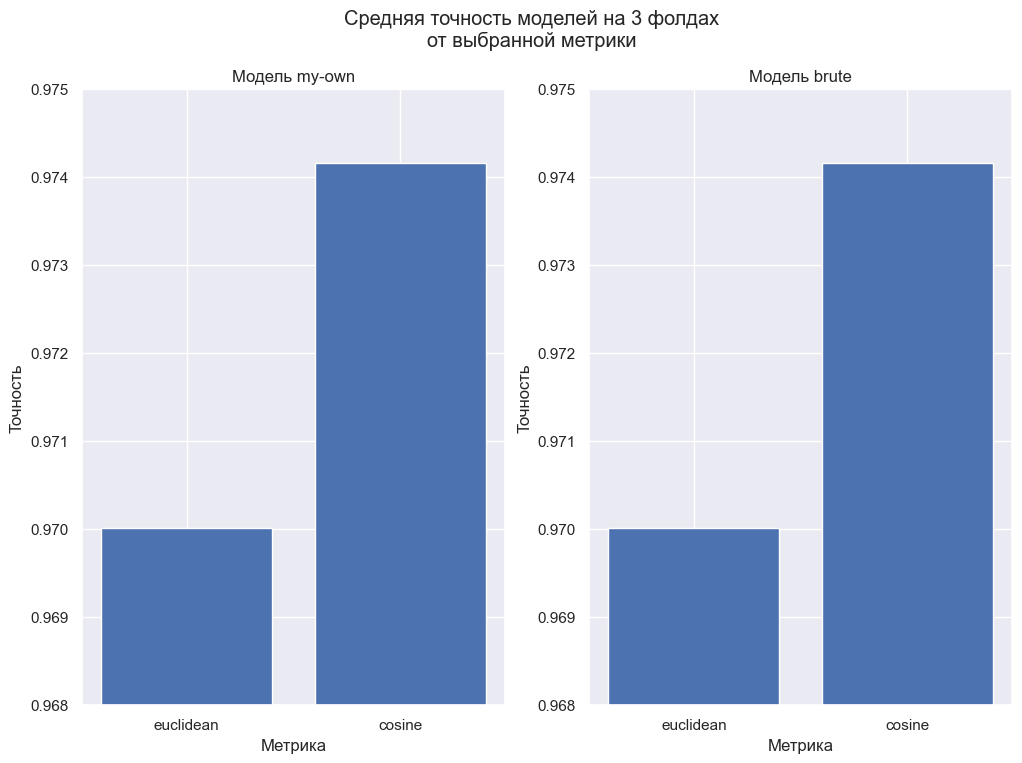

In [43]:
figure, axis = plt.subplots(1, 2)

x = np.arange(2)
plt.subplot(1,2,1)
plt.bar(x, my_mean_cv_score, align='center')
plt.xticks(x, ['euclidean', 'cosine'])
plt.ylim((0.968,0.975))
plt.grid(True)
plt.xlabel('Метрика')
plt.ylabel('Точность')
plt.title('Модель my-own')

plt.subplot(1,2,2)
plt.bar(x, my_mean_cv_score, align='center')

plt.xticks(x, ['euclidean', 'cosine'])
plt.ylim((0.968,0.975))
plt.grid(True)
plt.xlabel('Метрика')
plt.ylabel('Точность')
plt.title('Модель brute')


figure.suptitle('Средняя точность моделeй на 3 фолдах\nот выбранной метрики')

figure.set_size_inches(12, 8)

plt.savefig('charts/metrics_cv.pdf')

plt.show()

## 3 Сравнение взвешенного и не взвешенного методов

In [44]:
np.random.seed(777)

cv_split10 = cv.kfold(X_train.shape[0], 10)

In [45]:
%%time

kd_cs_score_cosine_not_weighted = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split10, score = 'accuracy', 
                       strategy='brute', metric='cosine', weights=False) 
kd_cs_score_cosine_not_weighted

CPU times: user 12min 58s, sys: 1min 10s, total: 14min 8s
Wall time: 4min 20s


{3: [0.9756666666666667,
  0.9766666666666667,
  0.978,
  0.9755,
  0.977,
  0.976,
  0.9733333333333334,
  0.9761666666666666,
  0.9768333333333333,
  0.9781666666666666]}

In [46]:
%%time

kd_cs_score_cosine_weighted = cv.knn_cross_val_score(X = X_train, y = y_train, k_list=[3], cv = cv_split10, score = 'accuracy', 
                       strategy='brute', metric='cosine', weights=True) 
kd_cs_score_cosine_weighted

CPU times: user 13min, sys: 1min 10s, total: 14min 11s
Wall time: 4min 24s


{3: [0.9765,
  0.977,
  0.9788333333333333,
  0.9763333333333334,
  0.9778333333333333,
  0.977,
  0.9745,
  0.9776666666666667,
  0.9766666666666667,
  0.9791666666666666]}

In [47]:
df1 = pd.DataFrame()
df1['Фолд'] = np.arange(20)%10 + 1
df1['Метод'] = ['Взвешенный']*10 + ['Не взвешенный']*10
df1['Точность'] = kd_cs_score_cosine_weighted[3] + kd_cs_score_cosine_not_weighted[3]

df1

,Фолд,Метод,Точность
0,1,Взвешенный,0.976500
1,2,Взвешенный,0.977000
2,3,Взвешенный,0.978833
3,4,Взвешенный,0.976333
4,5,Взвешенный,0.977833
5,6,Взвешенный,0.977000
6,7,Взвешенный,0.974500
7,8,Взвешенный,0.977667
8,9,Взвешенный,0.976667
9,10,Взвешенный,0.979167


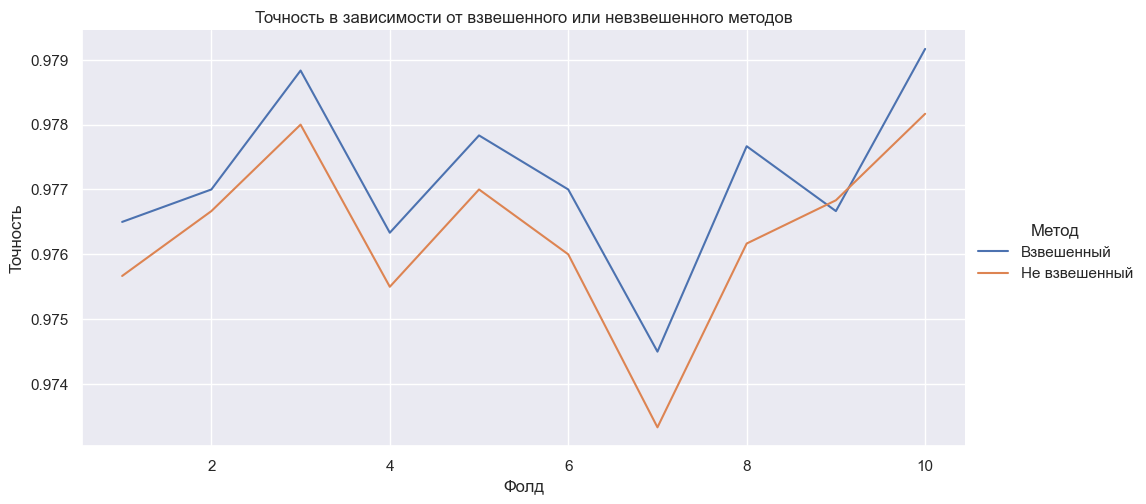

In [170]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.relplot(data=df1, x = 'Фолд', y = 'Точность', hue = 'Метод', kind = 'line', height=5, aspect=2)

plt.title('Точность в зависимости от взвешенного или невзвешенного методов')
plt.grid(True)
plt.savefig('charts/weights.pdf')


plt.show()

## 4. Обучение лушчей модели и confusion matrix

In [173]:
%%time
brute = nn.KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
brute.fit(X_train, y_train)

CPU times: user 79.1 ms, sys: 158 ms, total: 237 ms
Wall time: 406 ms


In [174]:
%%time
y_pred = brute.predict(X_test)

CPU times: user 2min 42s, sys: 16.6 s, total: 2min 59s
Wall time: 52 s


In [51]:
print('Итоговая точность:', np.sum(y_pred == y_test)/len(y_test))

Итоговая точность: 0.9742


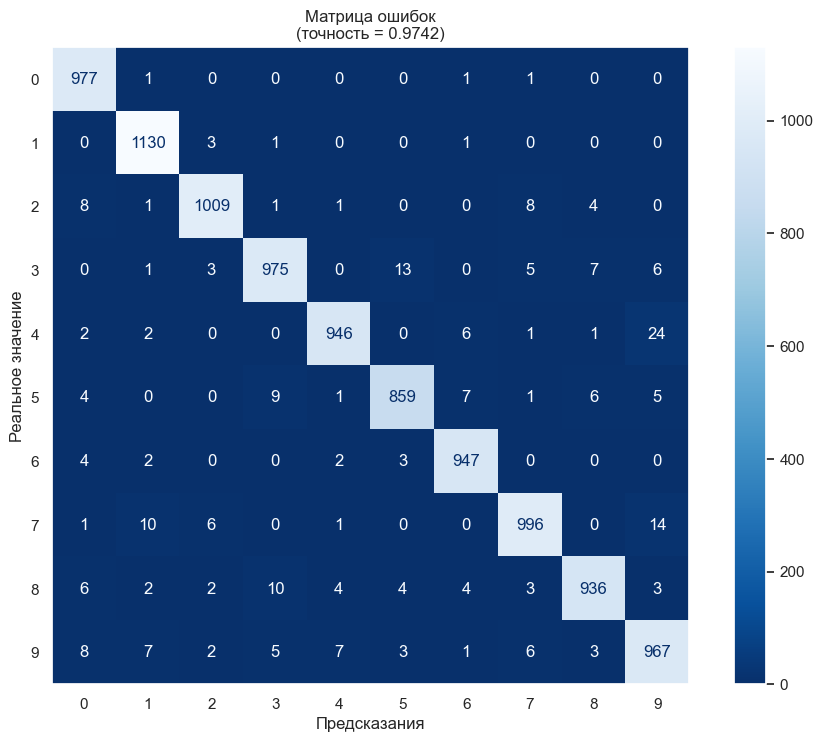

In [52]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_test, 
                                        display_labels=np.arange(10), cmap=plt.cm.Blues_r)
plt.grid(False)
plt.xlabel('Предсказания')
plt.ylabel('Реальное значение')
plt.title('Матрица ошибок\n(точность = ' + str(0.9742) + ')')
plt.savefig('charts/pred_proc_confusion.pdf')

plt.show()

[9 7 5 7 7 0 9 8 8 9 6 2 9 9 9 5 1 9 9 9]


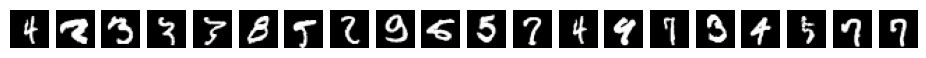

In [177]:
np.random.seed(777)
errors = np.where(y_pred != y_test)[0]
ind = np.random.randint(0, errors.shape, 20)
print(y_pred[errors[ind]])
show_images_horizontally(X_test[errors[ind]])

## 5. Аугментация

In [57]:
img_size = (28, 28)

In [58]:
np.random.seed(777)

cv_split = cv.kfold(30000, 3)

In [59]:
np.random.seed(777)

def get_augmented_sample(X, y, preprocess, n, *args):
    n_pictures = len(preprocess(X[0], *args)) + 1
    if n == -1:
        n = X.shape[0]*n_pictures
    X_augmented = np.zeros((X.shape[0]*n_pictures, X.shape[1]))
    index = 0
    for img in X:
        images = preprocess(img, *args)
        X_augmented[index] = img
        X_augmented[index+1:index+n_pictures] = images
        index += n_pictures

    ind = np.arange(X_augmented.shape[0])
    np.random.shuffle(ind)
    ind = ind[:n]
    X_augmented_sample = X_augmented[ind]
    
    y_sample = np.repeat(y, n_pictures)[ind]

    return (X_augmented_sample, y_sample)

In [60]:
np.random.seed(777)

def get_augmented_data(X, y, preprocess, params):
    n_pictures = len(preprocess(X[0], params[0]))
    X_augmented = np.zeros((X.shape[0]*(n_pictures*len(params)+1), X.shape[1]))
    index = 0
    
    for img in X:
        X_augmented[index] = img
        index += 1
        for param in params:
            images = preprocess(img, param)
            X_augmented[index : index + n_pictures] = images
            index += n_pictures 
    
    y = np.repeat(y, n_pictures*len(params) + 1)
    return (X_augmented, y)

### 5.1 Поворот

In [61]:
def rotate_image(image, angle):
    image = image.reshape(img_size).astype('float32')
    image_center = (img_size[0]/2, img_size[0]/2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result1 = cv2.warpAffine(image, rot_mat, img_size).flatten()
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result2 = cv2.warpAffine(image, rot_mat, img_size).flatten()
    return (result1, result2)

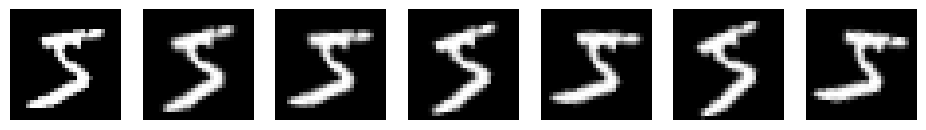

In [181]:
rotations = [5, 10, 15]
rotated_images = [X_train[0]]
for rotation in rotations:
    img1, img2 = rotate_image(X_train[0], rotation)
    rotated_images.append(img1)
    rotated_images.append(img2)

show_images_horizontally(rotated_images, 'rotated.jpg')

In [63]:
%%time
rotates = 5*(1 + np.arange(3))
cv_scores_rotated = []

for rotate in rotates:
    
    X_augmented_sample, y_sample = get_augmented_sample(X_train, y_train, rotate_image, 30000 , rotate)
    
    cv_scores_rotated.append(cv.knn_cross_val_score(X = X_augmented_sample, y = y_sample, 
                                               k_list=[3], cv = cv_split, score = 'accuracy', 
                                               strategy='brute', metric='cosine', weights=True, test_block_size = 10000)) 

for i in range(len(rotates)):
    print(rotates[i], ' -> ', cv_scores_rotated[i])

5  ->  {3: [0.9751, 0.9699, 0.9733]}
10  ->  {3: [0.9656, 0.9636, 0.9639]}
15  ->  {3: [0.9574, 0.9547, 0.9583]}
CPU times: user 7min 15s, sys: 43 s, total: 7min 58s
Wall time: 2min 22s


In [186]:
for score in cv_scores_rotated:
    print(np.mean(score[3]))

0.9727666666666667
0.9643666666666667
0.9568


### 5.2 Сдвиг

In [64]:
def shift_image(image, shift):
    image = image.reshape(img_size).astype('float32')
    res1 = scipy.ndimage.shift(image, [shift, 0]).flatten()
    res2 = scipy.ndimage.shift(image, [0, shift]).flatten()
    res3 = scipy.ndimage.shift(image, [-shift, 0]).flatten()
    res4 = scipy.ndimage.shift(image, [0, -shift]).flatten()

    return (res1, res2, res3, res4)

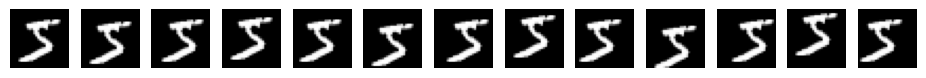

In [180]:
shifts = 1 + np.arange(3)
shifted_images = [X_train[0]]
for shift in shifts:
    shifted_images.extend(shift_image(X_train[0], shift))

show_images_horizontally(shifted_images, 'shifted.jpg')

In [66]:
%%time
shifts = 1 + np.arange(3)
cv_scores_shifted = []

for shift in shifts:
    
    X_augmented_sample, y_sample = get_augmented_sample(X_train, y_train, shift_image, 30000, shift)
    
    cv_scores_shifted.append(cv.knn_cross_val_score(X = X_augmented_sample, y = y_sample, 
                                               k_list=[3], cv = cv_split, score = 'accuracy', 
                                               strategy='brute', metric='cosine', weights=True, test_block_size = 10000)) 

for i in range(len(shifts)):
    print(shifts[i], ' -> ', cv_scores_shifted[i])

1  ->  {3: [0.9611, 0.9547, 0.9568]}
2  ->  {3: [0.9416, 0.947, 0.9475]}
3  ->  {3: [0.9422, 0.9441, 0.9439]}
CPU times: user 8min 29s, sys: 45.7 s, total: 9min 15s
Wall time: 3min 41s


In [184]:
for score in cv_scores_shifted:
    print(np.mean(score[3]))

0.9575333333333332
0.9453666666666667
0.9434


### 5.3 Блюр

In [67]:
def get_blured(image, sigma):
    image = image.reshape(28, 28).astype(float)
    img = cv2.GaussianBlur(image, (3, 3), sigma).flatten()
    return (img,)

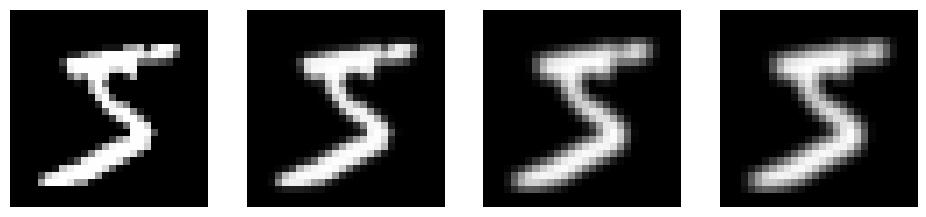

In [182]:
sigmas = 0.5 * (1+np.arange(3))
blured_images = [X_train[0]]
for sigma in sigmas:
    img = get_blured(X_train[0], sigma)
    blured_images.extend(img)

show_images_horizontally(blured_images, 'blured.jpg')

In [69]:
%%time
sigmas = 0.5 * (1+np.arange(3))
cv_scores_blured = []

for sigma in sigmas:
    X_augmented_sample, y_sample = get_augmented_sample(X_train, y_train, get_blured, 30000, sigma)
    cv_scores_blured.append(cv.knn_cross_val_score(X = X_augmented_sample, y = y_sample, 
                                           k_list=[3], cv = cv_split, score = 'accuracy', 
                                           strategy='brute', metric='cosine', weights=True, test_block_size = 10000)) 

for i in range(len(sigmas)):
    print(sigmas[i], ' -> ', cv_scores_blured[i])

0.5  ->  {3: [0.9749, 0.9735, 0.9707]}
1.0  ->  {3: [0.9722, 0.9736, 0.9724]}
1.5  ->  {3: [0.9751, 0.9718, 0.9728]}
CPU times: user 7min 18s, sys: 44.3 s, total: 8min 2s
Wall time: 2min 18s


In [185]:
for score in cv_scores_blured:
    print(np.mean(score[3]))

0.9730333333333333
0.9727333333333333
0.9732333333333333


### 5.4 Эрозия, дилатация, открытие, закрытие

In [70]:
def get_morphed(image, type):
    image = image.reshape(28, 28).astype(float)
    kernel = np.ones((2,2))

    img = cv2.morphologyEx(image, type, kernel).flatten()
    return (img, )

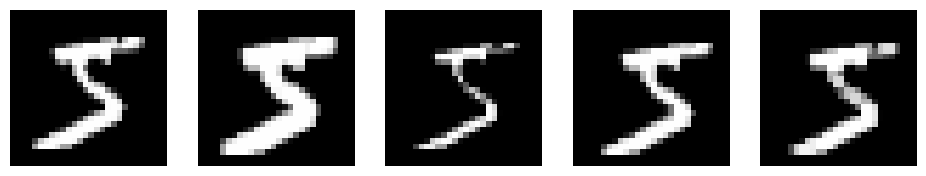

In [183]:
kind = [cv2.MORPH_DILATE, cv2.MORPH_ERODE, cv2.MORPH_CLOSE, cv2.MORPH_OPEN]

morphed_images = []
morphed_images.append(X_train[0])

for type in kind:
    imgs = get_morphed(X_train[0], type)
    morphed_images.extend(imgs)

show_images_horizontally(morphed_images, 'morphed.jpg')

In [72]:
%%time
kind = [cv2.MORPH_DILATE, cv2.MORPH_ERODE, cv2.MORPH_CLOSE, cv2.MORPH_OPEN]
morph_names = ['dilate', 'erode', 'close', 'open']
cv_scores_morphed = []

for type in kind:
    X_augmented_sample, y_sample = get_augmented_sample(X_train, y_train, get_morphed, 30000, type)
    cv_scores_morphed.append(cv.knn_cross_val_score(X = X_augmented_sample, y = y_sample, 
                                                    k_list=[3], cv = cv_split, score = 'accuracy', 
                                                    strategy='brute', metric='cosine', weights=True, test_block_size = 10000))
    
for i in range(len(kind)):
    print(morph_names[i], ' -> ', cv_scores_morphed[i])

dilate  ->  {3: [0.9645, 0.9648, 0.9638]}
erode  ->  {3: [0.9536, 0.9566, 0.9582]}
close  ->  {3: [0.9607, 0.9576, 0.9596]}
open  ->  {3: [0.9561, 0.9594, 0.959]}
CPU times: user 9min 37s, sys: 59 s, total: 10min 36s
Wall time: 3min 4s


In [187]:
for score in cv_scores_morphed:
    print(np.mean(score[3]))

0.9643666666666667
0.9561333333333334
0.9592999999999999
0.9581666666666666


### 5.5 Обучение модели

In [73]:
%%time
procs = [rotate_image, shift_image, get_blured, get_morphed, get_morphed, get_morphed, get_morphed]
args = [5, 1, 1.5, cv2.MORPH_DILATE, cv2.MORPH_ERODE, cv2.MORPH_CLOSE, cv2.MORPH_OPEN]
confusion_matrixes5 = []
errors_list5 = []
accurancy_list5 = []

for i in range(len(procs)):
    X_augmented_sample, y_sample = get_augmented_sample(X_train, y_train, procs[i], -1, args[i])
    brute = nn.KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=10000)
    brute.fit(X_augmented_sample, y_sample)
    y_pred = brute.predict(X_test)
    confusion_matrixes5.append(confusion_matrix(y_test, y_pred, labels = np.arange(10)))
    errors_list5.append(np.where(y_pred != y_test)[0])
    accurancy_list5.append(np.sum(y_pred == y_test)/len(y_test))


CPU times: user 43min 22s, sys: 6min 9s, total: 49min 31s
Wall time: 16min 43s


In [74]:
accurancy_list5

[0.9784, 0.9805, 0.9802, 0.9766, 0.9735, 0.9754, 0.9749]

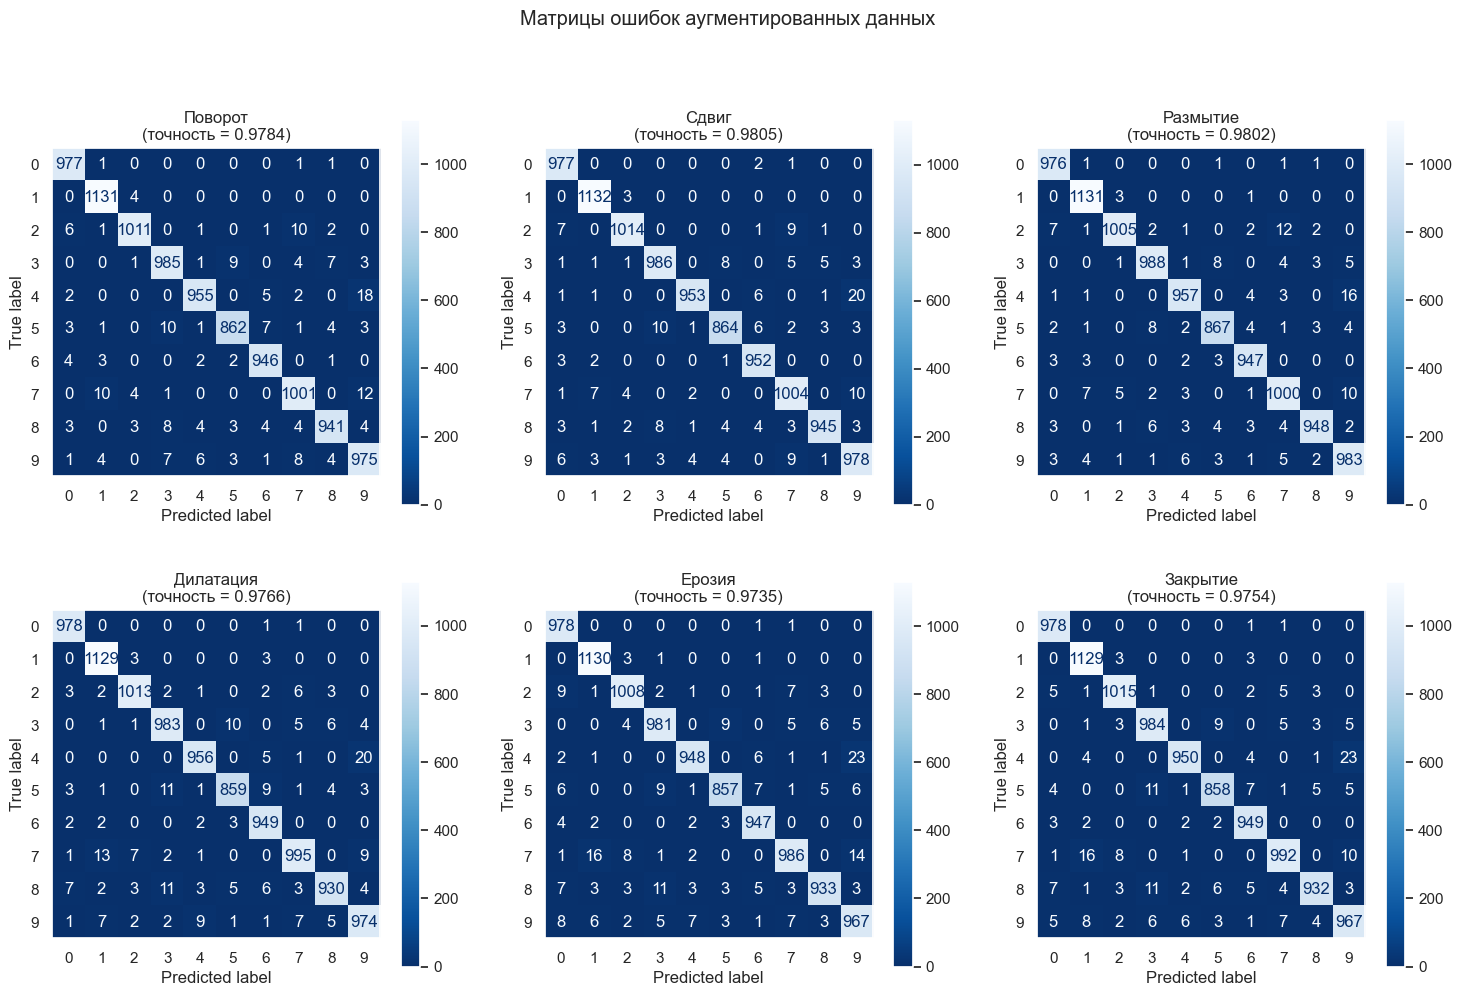

In [198]:
procs_names = ['Поворот', 'Сдвиг', 'Размытие', 'Дилатация', 'Ерозия', 'Закрытие']


figure, axis = plt.subplots(2, 3)
figure.set_size_inches(18, 11)
for i, conf_matrix in enumerate(confusion_matrixes5[:6]):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    axis[i//3, i%3].set_title(procs_names[i]+ '\n(точность = ' + str(accurancy_list5[i]) + ')')
    axis[i//3, i%3].set_xlabel('Предсказание')
    axis[i//3, i%3].set_ylabel('Верный класс')
    axis[i//3, i%3].grid(False)
    disp.plot(ax = axis[i//3, i%3], cmap=plt.cm.Blues_r)

plt.grid(False)
plt.suptitle('Матрицы ошибок аугментированных данных')
plt.savefig('charts/after_proc_train_confusion.pdf')
plt.show()

## 6. Голосование

In [76]:
%%time
brute = nn.KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
brute.fit(X_train, y_train)

CPU times: user 77.1 ms, sys: 99.2 ms, total: 176 ms
Wall time: 179 ms


In [77]:
rotates = 5*(1 + np.arange(3))
shifts = 1 + np.arange(3)
sigmas = 0.5 * (1+np.arange(3))
kind = [cv2.MORPH_DILATE, cv2.MORPH_ERODE, cv2.MORPH_CLOSE, cv2.MORPH_OPEN]

In [78]:
y_test1 = y_test[:1000]
X_test1 = X_test[:1000]

In [79]:
%%time
procs = [rotate_image, shift_image, get_blured, get_morphed]

params = [rotates, shifts, sigmas, kind]
confusion_matrixes6 = []
errors_list6 = []
accurancy_list6 = []

for i, proc in enumerate(procs):
    X_augmented_test, y_sample = get_augmented_data(X_test1, y_test1, proc, params[i])
    y_pred = brute.predict(X_augmented_test)
    d = len(y_pred)//len(y_test1)

    y_sample = y_sample[::d]
    y_pred = y_pred.reshape(len(y_test1), d)

    votes = np.ones(y_pred.shape)

    ans = np.zeros((10, votes.shape[0]))
    
    for i in np.arange(10):
        ans[i] = np.sum(votes * (y_pred == i), axis=1)
    
    y_pred = np.argmax(ans.T, axis=1)

    confusion_matrixes6.append(confusion_matrix(y_sample, y_pred, labels = np.arange(10)))
    errors_list6.append(np.where(y_pred != y_sample)[0])
    accurancy_list6.append(np.sum(y_pred == y_sample)/len(y_sample))

CPU times: user 7min 56s, sys: 40.4 s, total: 8min 36s
Wall time: 2min 19s


In [80]:
accurancy_list6

[0.975, 0.97, 0.968, 0.94]

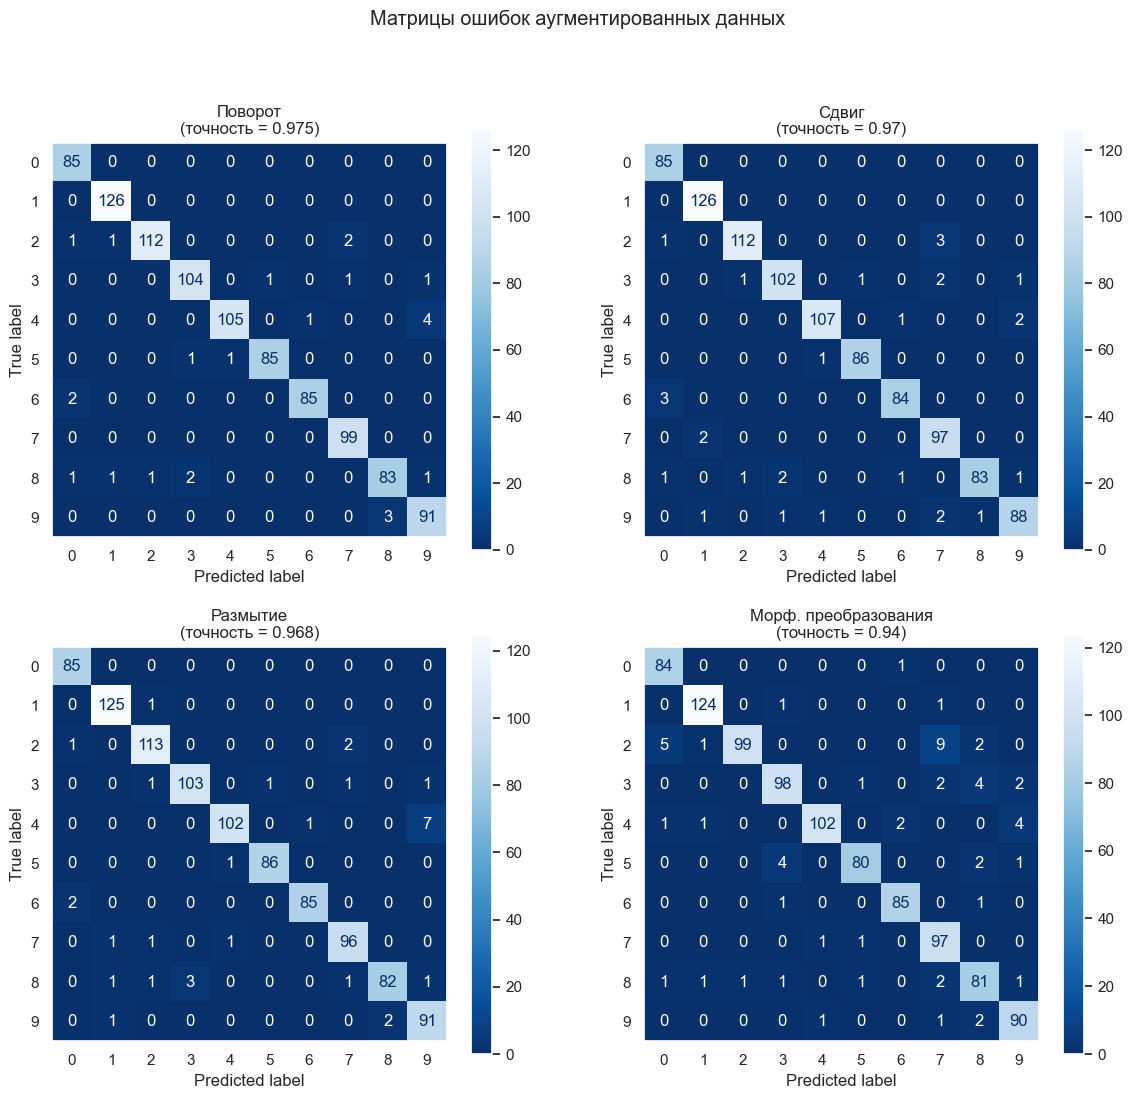

In [204]:
procs_names6 = ['Поворот', 'Сдвиг', 'Размытие', 'Морф. преобразования']


figure, axis = plt.subplots(2, 2)
figure.set_size_inches(14,12)
for i, conf_matrix in enumerate(confusion_matrixes6):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    axis[i//2, i%2].set_title(procs_names6[i]+ '\n(точность = ' + str(accurancy_list6[i]) + ')')
    axis[i//2, i%2].set_xlabel('Предсказание')
    axis[i//2, i%2].set_ylabel('Верный класс')
    axis[i//2, i%2].grid(False)
    disp.plot(ax = axis[i//2, i%2], cmap=plt.cm.Blues_r)

plt.suptitle('Матрицы ошибок аугментированных данных')
plt.savefig('charts/after_proc_test_confusion.pdf')
plt.show()